<a href="https://colab.research.google.com/github/zaraprvz/Diabetes-Prediction-Capstone-Project/blob/main/End_to_end_Churn_Prediction_Using_SageMaker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%html
<style>
table {float:left}
</style>

In [ ]:
!conda install -c conda-forge shap --upgrade
!pip install smdebug --upgrade
!pip install s3fs --upgrade
!pip install nbconvert

usage: conda [-h] [-v] [--no-plugins] [-V] COMMAND ...
conda: error: unrecognized arguments: --upgrade
  Using cached fsspec-2024.6.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.6.0-py3-none-any.whl (176 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
ERROR: Cannot uninstall fsspec 2023.6.0, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps fsspec==2023.6.0'.


In [ ]:
!pip install s3fs --upgrade
!pip install boto3
!pip install sagemaker
import re
import s3fs
# import shap
import time
import boto3
import pandas as pd
import numpy as np

from itertools import islice
import matplotlib.pyplot as plt

import sagemaker
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.debugger import DebuggerHookConfig,CollectionConfig
from sagemaker.debugger import rule_configs, Rule
from smdebug.trials import create_trial
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

  Using cached botocore-1.34.131-py3-none-any.whl.metadata (5.7 kB)
Using cached botocore-1.34.131-py3-none-any.whl (12.3 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.149
    Uninstalling botocore-1.34.149:
      Successfully uninstalled botocore-1.34.149
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.34.149 requires botocore<1.35.0,>=1.34.149, but you have botocore 1.34.131 which is incompatible.


  Using cached botocore-1.34.149-py3-none-any.whl.metadata (5.7 kB)
Using cached botocore-1.34.149-py3-none-any.whl (12.4 MB)
ERROR: Operation cancelled by user


In [ ]:
bucket = 'sagemaker-us-east-2-533267313146'

In [ ]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name


3. Preprocess Data

In [ ]:
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    ## Convert to datetime columns
    df["firstorder"] = pd.to_datetime(df["firstorder"],errors='coerce')
    df["lastorder"] = pd.to_datetime(df["lastorder"],errors='coerce')
    ## Drop Rows with null values
    df = df.dropna()
    ## Create Column which gives the days between the last order and the first order
    df["first_last_days_diff"] = (df['lastorder']-df['firstorder']).dt.days
    ## Create Column which gives the days between when the customer record was created and the first order
    df['created'] = pd.to_datetime(df['created'])
    df['created_first_days_diff']=(df['created']-df['firstorder']).dt.days
    ## Drop Columns
    df.drop(['custid','created','firstorder','lastorder'],axis=1,inplace=True)
    ## Apply one hot encoding on favday and city columns
    df = pd.get_dummies(df,prefix=['favday','city'],columns=['favday','city'])
    return df

In [ ]:
storedata = preprocess_data(f"s3://{bucket}/storedata_total.csv")

/tmp/ipykernel_117/601607182.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["firstorder"] = pd.to_datetime(df["firstorder"],errors='coerce')
/tmp/ipykernel_117/601607182.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["lastorder"] = pd.to_datetime(df["lastorder"],errors='coerce')
/tmp/ipykernel_117/601607182.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created'] = pd.to_datetime(df['created'])


In [ ]:
storedata.head()

,retained,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,first_last_days_diff,...,favday_Monday,favday_Saturday,favday_Sunday,favday_Thursday,favday_Tuesday,favday_Wednesday,city_BLR,city_BOM,city_DEL,city_MAA
0,0,29.0,100.000000,3.448276,14.52,0.000000,0.0,0.0,0.0,0,...,True,False,False,False,False,False,False,False,True,False
1,1,95.0,92.631579,10.526316,83.69,0.181641,1.0,1.0,1.0,1024,...,False,False,False,False,False,False,False,False,True,False
2,0,0.0,0.000000,0.000000,33.58,0.059908,0.0,0.0,0.0,217,...,False,False,False,False,False,True,False,False,True,False
3,0,0.0,0.000000,0.000000,54.96,0.000000,0.0,0.0,0.0,0,...,False,False,False,True,False,False,False,True,False,False
4,1,30.0,90.000000,13.333333,111.91,0.008850,0.0,0.0,0.0,791,...,True,False,False,False,False,False,False,True,False,False


4. Split Train, Test and Validation Datasets

In [ ]:
def split_datasets(df):
    y = df.pop("retained")
    X_pre = df
    y_pre = y.to_numpy().reshape(len(y), 1)
    feature_names = list(X_pre.columns)
    X = np.concatenate((y_pre,X_pre),axis=1)
    np.random.shuffle(X)
    train, validation, test = np.split(X,[int(.7*len(X)),int(.85*len(X))])
    return feature_names, train, validation, test

In [ ]:
feature_names, train, validation, test = split_datasets(storedata)

In [ ]:
pd.DataFrame(train).to_csv(f"s3://{bucket}/data/train/train.csv",header=False,index=False)
pd.DataFrame(validation).to_csv(f"s3://{bucket}/data/validation/validation.csv",header=False,index=False)
pd.DataFrame(test).to_csv(f"s3://{bucket}/data/test/test.csv",header=False,index=False)

5. Hyperparameter Tuning HPO

In [ ]:
s3_input_train = TrainingInput(
    s3_data=f"s3://{bucket}/data/train/", content_type="csv")
s3_input_validation = TrainingInput(
    s3_data=f"s3://{bucket}/data/validation/", content_type="csv")

In [ ]:
fixed_hyperparameters = {
    "eval_metric":"auc",
    "objective":"binary:logistic",
    "num_round":"100",
    "rate_drop":"0.3",
    "tweedie_variance_power":"1.4"
}

In [ ]:
sess = sagemaker.Session()
container = sagemaker.image_uris.retrieve("xgboost",region,"0.90-2")

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    hyperparameters=fixed_hyperparameters,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(bucket),
    sagemaker_session=sagemaker_session
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


In [ ]:
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
}

In [ ]:
objective_metric_name = "validation:auc"

In [ ]:
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=10,
    max_parallel_jobs=2)

In [ ]:
tuner.fit({
    "train":s3_input_train,
    "validation":s3_input_validation
    },
          include_cls_metadata=False)

INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-xgboost-240624-2046


..............................................................................!


In [ ]:
tuning_job_result = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)

In [ ]:
job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" %job_count)

10 training jobs have completed


In [ ]:
from pprint import pprint

if tuning_job_result.get("BestTrainingJob",None):
    print("Best Model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best Model found so far:
{'CreationTime': datetime.datetime(2024, 6, 24, 20, 52, 6, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:auc',
                                                 'Value': 0.9781079888343811},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2024, 6, 24, 20, 52, 38, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-2:533267313146:training-job/sagemaker-xgboost-240624-2046-010-30c0180b',
 'TrainingJobName': 'sagemaker-xgboost-240624-2046-010-30c0180b',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2024, 6, 24, 20, 52, 10, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '1.7356231131419788',
                          'eta': '0.2521187003543621',
                          'max_depth': '5',
                          'min_child_weight': '8.839272296358354'}}


In [ ]:
best_hyperparameters = tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]

In [ ]:
best_hyperparameters

{'alpha': '1.7356231131419788',
 'eta': '0.2521187003543621',
 'max_depth': '5',
 'min_child_weight': '8.839272296358354'}

7. XGBoost Model with SageMaker Debugger

In [ ]:
hyperparameters = {**fixed_hyperparameters, **best_hyperparameters}
save_interval = 5
base_job_name = "demo-smdebug-xgboost-churn-classification"

In [ ]:
container = sagemaker.image_uris.retrieve("xgboost", region, "0.90-2")

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


In [ ]:
estimator = sagemaker.estimator.Estimator(
    container,
    role,
    base_job_name=base_job_name,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(bucket),
    sagemaker_session=sess,
    hyperparameters=hyperparameters,
    max_run=1800,
    debugger_hook_config = DebuggerHookConfig(
        s3_output_path=f"s3://{bucket}/debugger/",  # Required
        collection_configs=[
            CollectionConfig(
                name="metrics",
                parameters={
                    "save_interval": "5"
                }),
            CollectionConfig(
                name="feature_importance", parameters={"save_interval": "5"}
            ),
            CollectionConfig(name="full_shap", parameters={"save_interval": "5"}),
            CollectionConfig(name="average_shap", parameters={"save_interval": "5"}),
        ]
    ),
    rules=[
        Rule.sagemaker(
            rule_configs.loss_not_decreasing(),
            rule_parameters={
                "collection_names": "metrics",
                "num_steps": "10",
            },
        ),
    ]
)

In [ ]:
estimator.fit(
        {"train":s3_input_train,"validation":s3_input_validation},wait=False
    )

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: demo-smdebug-xgboost-churn-classificati-2024-06-24-20-52-44-659


In [ ]:
for _ in range(36):
    job_name = estimator.latest_training_job.name
    client = estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description["TrainingJobStatus"]
    rule_job_summary = estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]["RuleEvaluationStatus"]
    print(
        "Training job status: {}, Rule Evaluation Status: {}".format(
            training_job_status, rule_evaluation_status
        )
    )
    if training_job_status in ["Completed", "Failed"]:
        break
    time.sleep(10)

Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation Status: InProgress
Training job status: InProgress, Rule Evaluation

8. Analyze Debugger Output

In [ ]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-2:533267313146:processing-job/demo-smdebug-xgboost-churn-LossNotDecreasing-9ffd8d77',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2024, 6, 24, 20, 55, 28, 555000, tzinfo=tzlocal())}]

In [ ]:
s3_output_path = estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2024-06-24 20:55:36.907 default:117 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-2-533267313146/debugger/demo-smdebug-xgboost-churn-classificati-2024-06-24-20-52-44-659/debug-output


In [ ]:
trial.tensor_names()

[2024-06-24 20:55:37.784 default:117 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-06-24 20:55:38.802 default:117 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f10',
 'average_shap/f11',
 'average_shap/f12',
 'average_shap/f13',
 'average_shap/f14',
 'average_shap/f15',
 'average_shap/f16',
 'average_shap/f17',
 'average_shap/f18',
 'average_shap/f19',
 'average_shap/f2',
 'average_shap/f20',
 'average_shap/f3',
 'average_shap/f4',
 'average_shap/f5',
 'average_shap/f6',
 'average_shap/f7',
 'average_shap/f8',
 'average_shap/f9',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/cover/f4',
 'feature_importance/cover/f5',
 'feature_importance/cover/f6',
 'feature_importance/cover/f7',
 'feature_importance/cover/f8',
 'feature_importance/cover/f9',
 'feature_importance/gain/f0',
 'feature_importance/gain/f1',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/gain/f4',
 'feature_importance/gain/f5',
 'feature_importance/gain/f6',
 'feature_importance/gain/f7',
 

In [ ]:
trial.tensor("average_shap/f1").values()

{0: array([-0.00128914], dtype=float32),
 5: array([-0.00256535], dtype=float32),
 10: array([0.00970752], dtype=float32),
 15: array([0.01783861], dtype=float32),
 20: array([0.04898213], dtype=float32),
 25: array([0.08433824], dtype=float32),
 30: array([0.10616551], dtype=float32),
 35: array([0.11841498], dtype=float32),
 40: array([0.14064585], dtype=float32),
 45: array([0.13158953], dtype=float32),
 50: array([0.14109655], dtype=float32),
 55: array([0.1535306], dtype=float32),
 60: array([0.17396022], dtype=float32),
 65: array([0.17033027], dtype=float32),
 70: array([0.17161812], dtype=float32),
 75: array([0.17902988], dtype=float32),
 80: array([0.17913789], dtype=float32),
 85: array([0.18128444], dtype=float32),
 90: array([0.17820387], dtype=float32),
 95: array([0.17369166], dtype=float32)}

In [ ]:
MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1] == "f{}".format(str(ifeat)):
            return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")

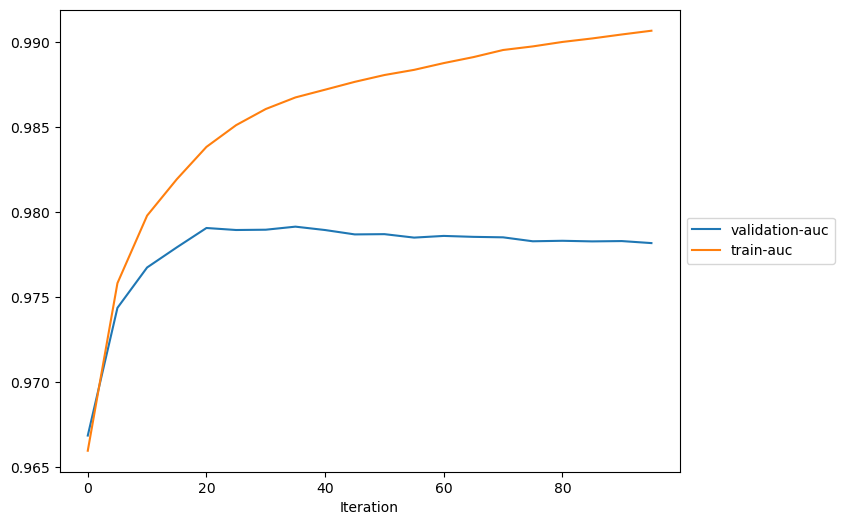

In [ ]:
plot_collection(trial, "metrics")

In [ ]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ["weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial, "feature_importance", regex=f"feature_importance/{importance_type}/.*")

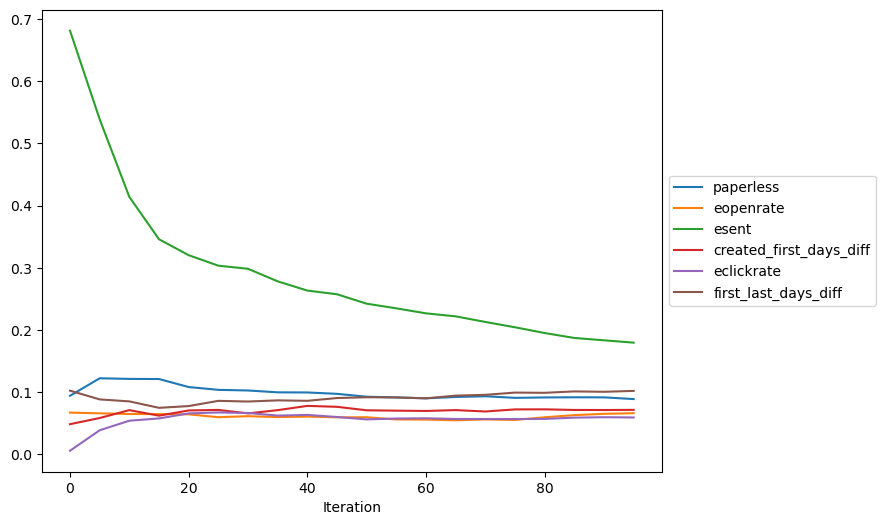

In [ ]:
plot_feature_importance(trial, importance_type="cover")

SHAP

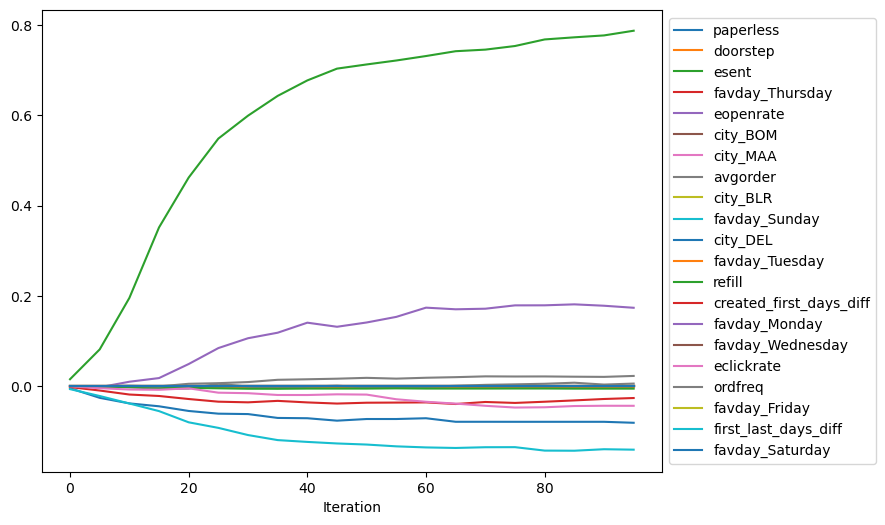

In [ ]:
plot_collection(trial, "average_shap")

Global Explanations

Note: you may need to restart the kernel to use updated packages.


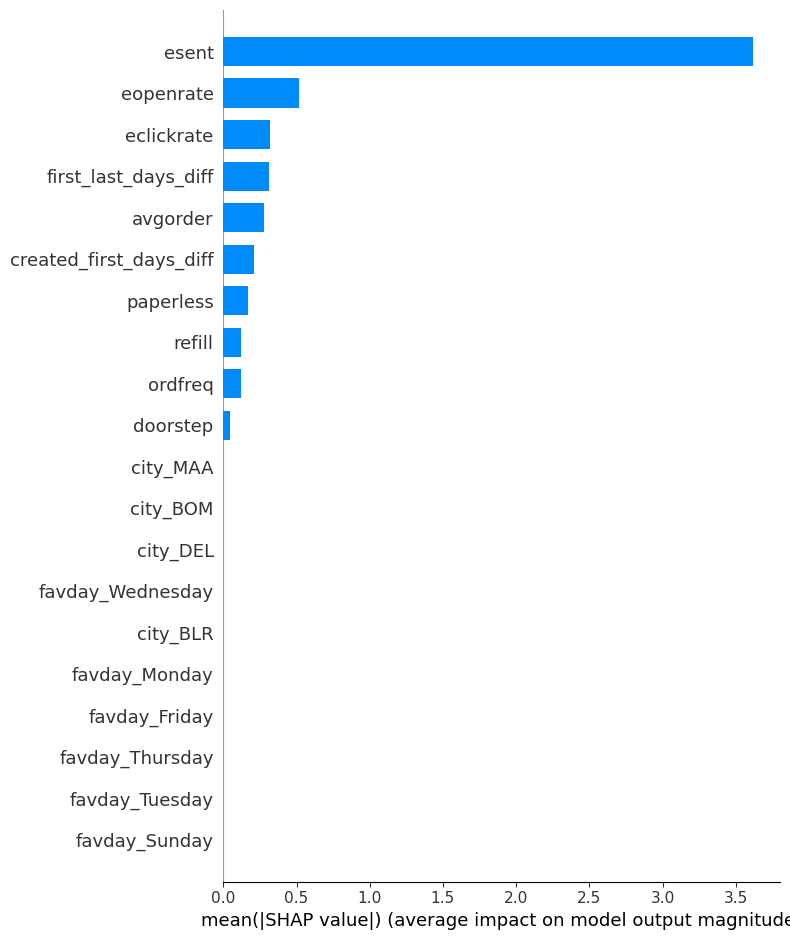

In [ ]:
%pip install shap

import shap

shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

In [ ]:
shap_base_value

2.1492383

In [ ]:
train_shap = pd.DataFrame(train[:,1:],columns=feature_names)

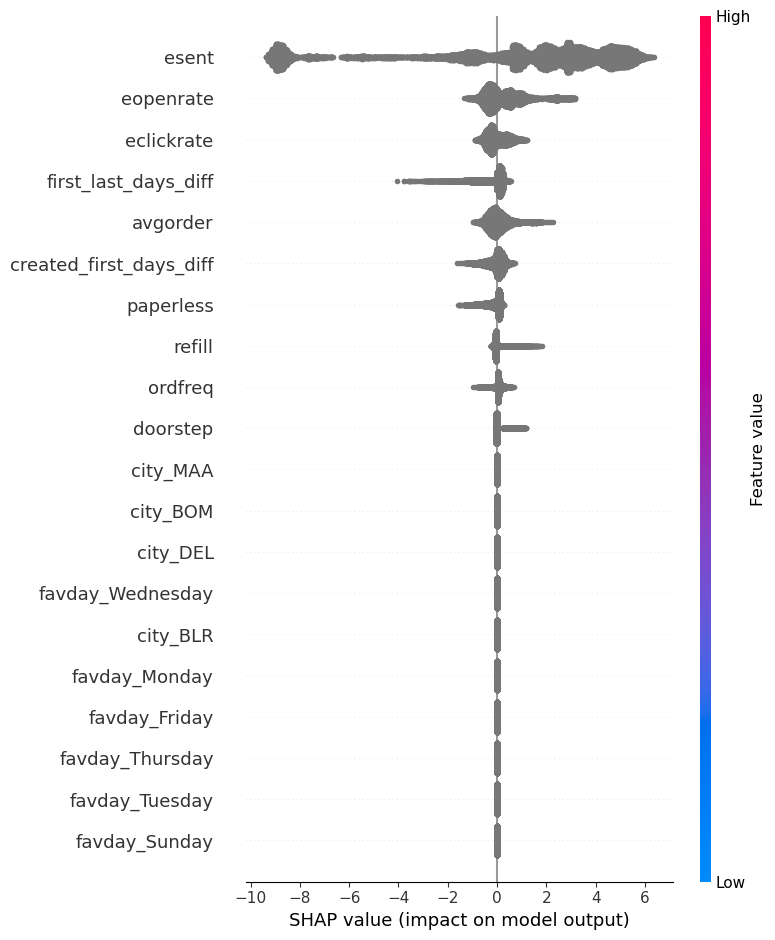

In [ ]:
shap.summary_plot(shap_no_base, train_shap)

Local Explanations

In [ ]:
shap.initjs()

In [ ]:
shap.force_plot(
    shap_base_value,
    shap_no_base[100, :],
    train_shap.iloc[100, :],
    link="logit",
    matplotlib=False,
)

In [ ]:
N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(100, N_ROWS)
sampled_indices = np.random.randint(N_ROWS, size=N_SAMPLES)

In [ ]:
shap.force_plot(
    shap_base_value,
    shap_no_base[sampled_indices, :],
    train_shap.iloc[sampled_indices, :],
    link="logit",
)